In [2]:
#general libraries
import pandas as pd
import numpy as np
import getpass

#SQL
import pymysql
from sqlalchemy import create_engine
#plot
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib

#from scipy.stats import normaltest
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import Normalizer, StandardScaler, PowerTransformer

from sklearn.metrics import confusion_matrix, plot_confusion_matrix, cohen_kappa_score, accuracy_score, classification_report

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks


Using matplotlib backend: Qt5Agg


C:\Users\Borja\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# 2. Gather the data

In [3]:
password = getpass.getpass()

········


In [4]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/credit_card_classification'
engine = create_engine(connection_string)
engine.execute("USE credit_card_classification")

In [5]:
query="""select * from credit_card_classification.credit_card_data_2"""
data = pd.read_sql_query(query, engine)
data

,customer_number,offer_accepted,reward,mailer_type,income_level,bank_accounts_open,overdraft_protection,credit_rating,credit_cards_held,homes_owned,household_size,own_your_home,balance,average_balance_q1,average_balance_q2,average_balance_q3,average_balance_q4
0,1,No,Air Miles,Letter,High,1,No,High,2,1,4,No,1160.75,1669,877,1095,1002
1,2,No,Air Miles,Letter,Medium,1,No,Medium,2,2,5,Yes,147.25,39,106,78,366
2,3,No,Air Miles,Postcard,High,2,No,Medium,2,1,2,Yes,276.50,367,352,145,242
3,4,No,Air Miles,Letter,Medium,2,No,High,1,1,4,No,1219.00,1578,1760,1119,419
4,5,No,Air Miles,Letter,Medium,1,No,Medium,2,1,6,Yes,1211.00,2140,1357,982,365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17971,17996,No,Cash Back,Letter,High,1,No,Low,1,1,5,Yes,167.50,136,65,71,398
17972,17997,No,Cash Back,Letter,High,1,No,Low,3,1,3,Yes,850.50,984,940,943,535
17973,17998,No,Cash Back,Letter,High,1,No,Low,2,1,4,No,1087.25,918,767,1170,1494
17974,17999,No,Cash Back,Letter,Medium,1,No,Medium,4,2,2,Yes,1022.25,626,983,865,1615


Note, 24 rows were dropped by MySQL in the import from the original CSV file to SQL, because some columns were empty (balance & co). We estimate that 24 out of a total of 18000 is not significant.

Next, we make a copy of the original dataframe so that we can use it again later

In [426]:
data2 = data.copy()

# 3. Clean the data

Check for nulls and see data types

In [35]:
display(data2.info())
display(data2.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17976 entries, 0 to 17975
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   customer_number       17976 non-null  int64  
 1   offer_accepted        17976 non-null  object 
 2   reward                17976 non-null  object 
 3   mailer_type           17976 non-null  object 
 4   income_level          17976 non-null  object 
 5   bank_accounts_open    17976 non-null  int64  
 6   overdraft_protection  17976 non-null  object 
 7   credit_rating         17976 non-null  object 
 8   credit_cards_held     17976 non-null  int64  
 9   homes_owned           17976 non-null  int64  
 10  household_size        17976 non-null  int64  
 11  own_your_home         17976 non-null  object 
 12  balance               17976 non-null  float64
 13  average_balance_q1    17976 non-null  int64  
 14  average_balance_q2    17976 non-null  int64  
 15  average_balance_q3 

None

customer_number         0
offer_accepted          0
reward                  0
mailer_type             0
income_level            0
bank_accounts_open      0
overdraft_protection    0
credit_rating           0
credit_cards_held       0
homes_owned             0
household_size          0
own_your_home           0
balance                 0
average_balance_q1      0
average_balance_q2      0
average_balance_q3      0
average_balance_q4      0
dtype: int64

Check value counts to see if the data is imbalanced

We see aswell that the data imported was already cleaned as there are no further null values as those 24 previously mentioned.

We doublecheck using isna() and we see we get the same results.

# 4. Explore the data, select features to be used for the model

In [427]:
# We now set the dataframe index to be the customer_number so that it is not used for the model but, 
# we don't lose the information in case we need it afterwards.
data2.set_index('customer_number', inplace=True) 

# we remove the first element of the list "Customer number" since all of the ids are going to be different. 
# We also remove the balance features due to the same reason.
columns = list(data2.columns)
del columns[11:]

for col in columns:
    display(data2[col].value_counts())

No     16955
Yes     1021
Name: offer_accepted, dtype: int64

Air Miles    6047
Cash Back    5995
Points       5934
Name: reward, dtype: int64

Postcard    9134
Letter      8842
Name: mailer_type, dtype: int64

Medium    9002
High      4519
Low       4455
Name: income_level, dtype: int64

1    13674
2     4007
3      295
Name: bank_accounts_open, dtype: int64

No     15300
Yes     2676
Name: overdraft_protection, dtype: int64

High      6064
Medium    5964
Low       5948
Name: credit_rating, dtype: int64

2    7933
1    6147
3    3381
4     515
Name: credit_cards_held, dtype: int64

1    14502
2     3289
3      185
Name: homes_owned, dtype: int64

3    5705
4    5532
5    2851
2    2809
1     539
6     538
9       1
8       1
Name: household_size, dtype: int64

Yes    11636
No      6340
Name: own_your_home, dtype: int64

We see that our dependent feature, "offer accepted" is very imbalanced. This will lead to bad results of the ML model, we will most likely need to use oversampling techniques. 

In addition, household size could be problematic for households higher than 6.


'Correlation matrix among all numerical variables'

,bank_accounts_open,credit_cards_held,homes_owned,household_size,balance,average_balance_q1,average_balance_q2,average_balance_q3,average_balance_q4
bank_accounts_open,1.000000,-0.001633,0.004762,0.008622,-0.003909,-0.002814,-0.007956,0.000190,-0.000356
credit_cards_held,-0.001633,1.000000,-0.002390,-0.003040,-0.003469,-0.009446,-0.007373,-0.007623,0.015362
homes_owned,0.004762,-0.002390,1.000000,0.005227,0.017967,0.013143,0.009758,0.007775,0.014775
household_size,0.008622,-0.003040,0.005227,1.000000,-0.003582,-0.005080,-0.008766,0.003633,0.000232
balance,-0.003909,-0.003469,0.017967,-0.003582,1.000000,0.481507,0.800285,0.752741,0.572380
average_balance_q1,-0.002814,-0.009446,0.013143,-0.005080,0.481507,1.000000,0.483134,-0.060961,-0.237283
average_balance_q2,-0.007956,-0.007373,0.009758,-0.008766,0.800285,0.483134,1.000000,0.487710,0.168955
average_balance_q3,0.000190,-0.007623,0.007775,0.003633,0.752741,-0.060961,0.487710,1.000000,0.565298
average_balance_q4,-0.000356,0.015362,0.014775,0.000232,0.572380,-0.237283,0.168955,0.565298,1.000000


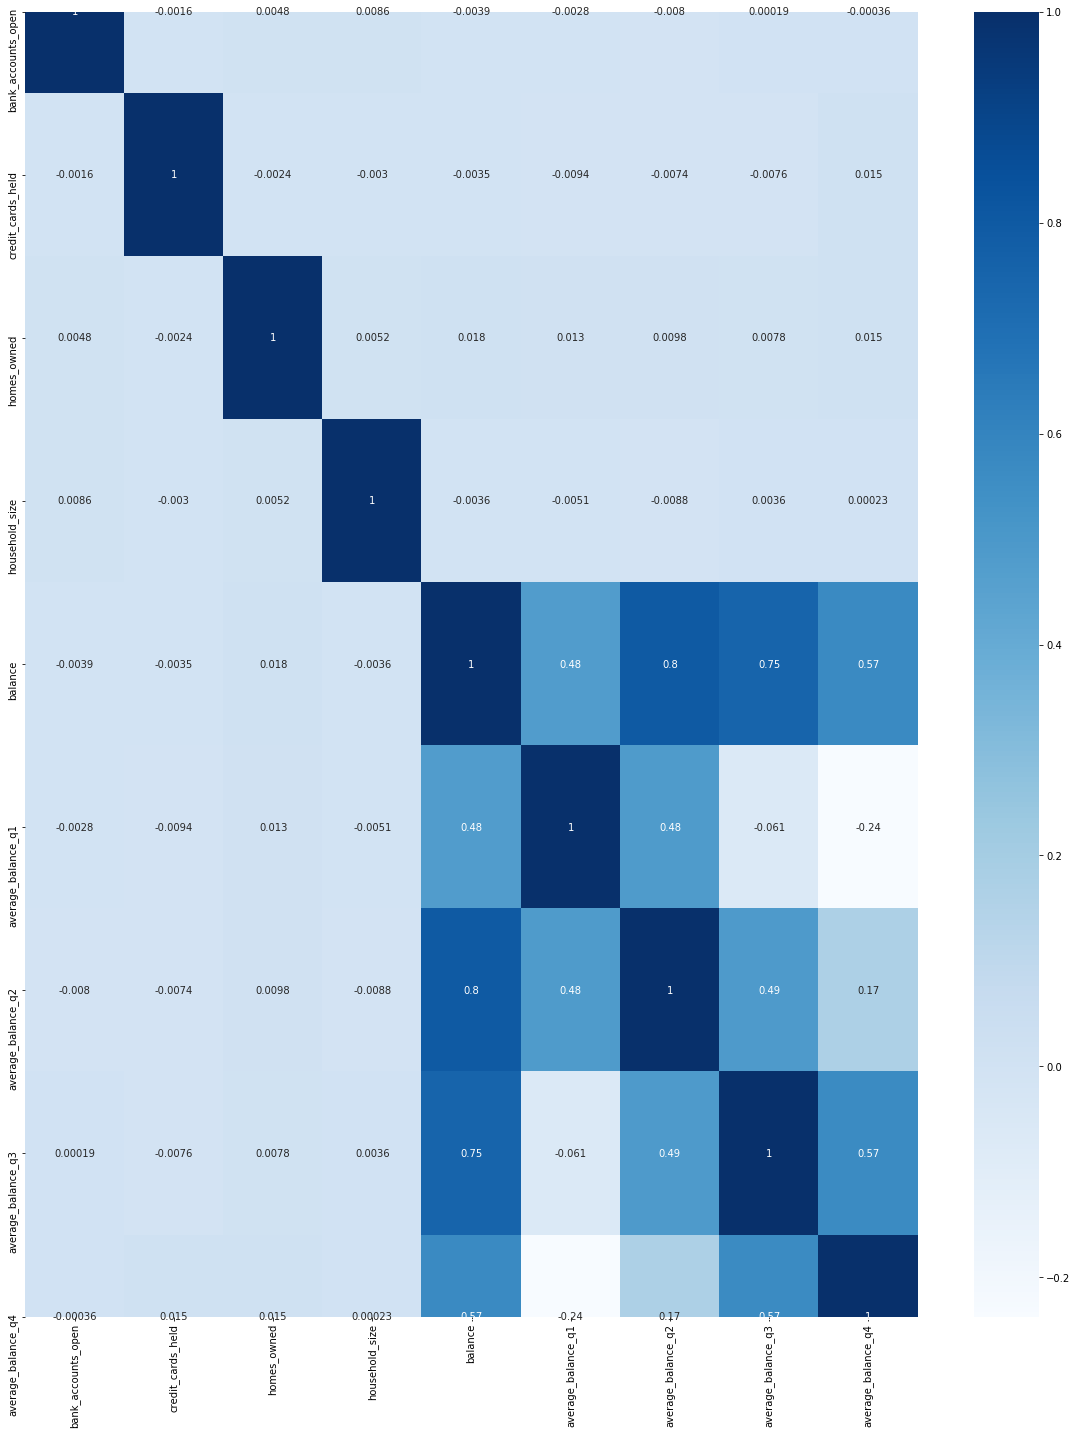

In [86]:
display('Correlation matrix among all numerical variables')
correlation_matrix = data2.select_dtypes(exclude='object').corr()
display(correlation_matrix)
plt.figure(figsize=(20, 24))
ax = sns.heatmap(correlation_matrix, annot=True, cmap='Blues', fmt='.2g') 
plt.show()

We see, in most cases, a low correlation between the independent features, which is a good result for our model.

Except for the average balance and the quarters, which makes sense since balance is the average of the other 4.

Let's see the distribution of the numerical features.

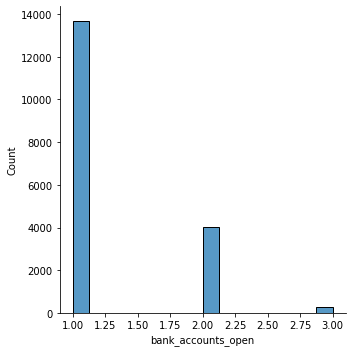

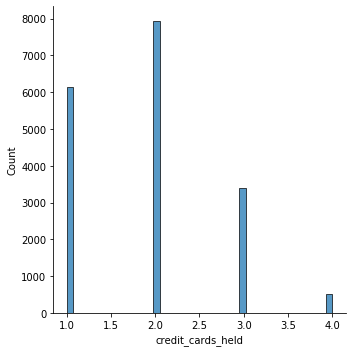

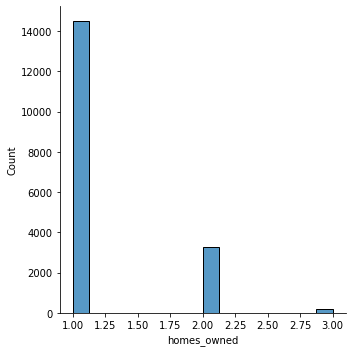

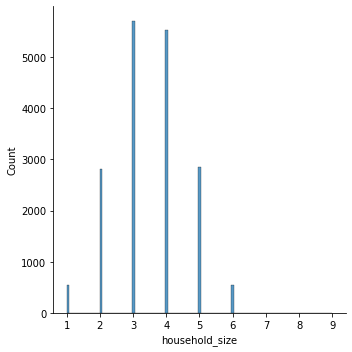

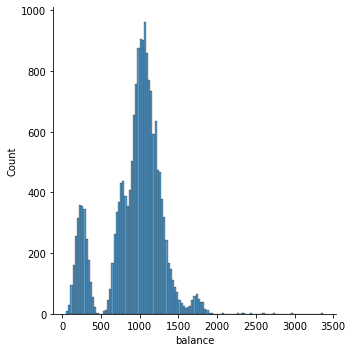

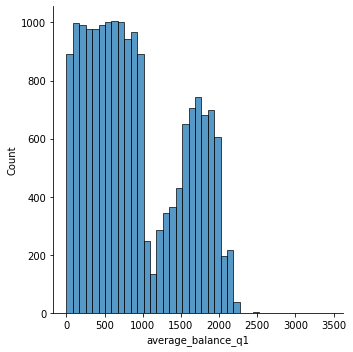

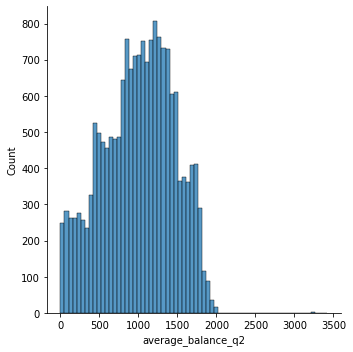

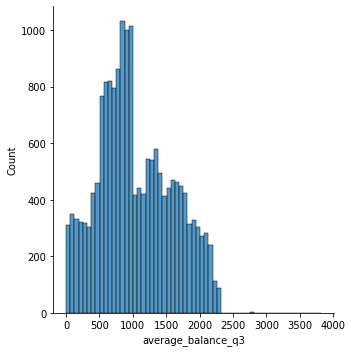

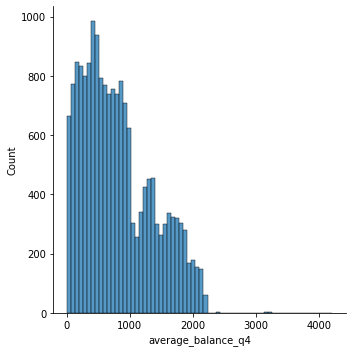

In [87]:
for col in data2.select_dtypes(exclude='object').columns:
    sns.displot(data2[col])
    plt.show()

# What do we say about the distribution graphs??????????????????

### VIF calculation for numerical features

In [78]:
vif = pd.DataFrame()
vif['variable'] = data2.select_dtypes(exclude='object').columns
vif['VIF'] = [variance_inflation_factor(data2.select_dtypes(exclude='object').values, i) for i in range(data2.select_dtypes(exclude='object').shape[1])]


display(vif)

C:\Users\Borja\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,variable,VIF
0,bank_accounts_open,6.614891
1,credit_cards_held,5.688677
2,homes_owned,7.187923
3,household_size,8.113760
4,balance,inf
5,average_balance_q1,inf
6,average_balance_q2,inf
7,average_balance_q3,inf
8,average_balance_q4,inf


VIF determines the strength of the correlation between the independent variables. It is predicted by taking a variable and regressing it against every other variable.

VIF explanation:
- VIF starts at 1 and has no upper limit
- VIF = 1, no correlation between the independent variable and the other variables
- VIF exceeding 5 or 10 indicates high multicollinearity between this independent variable and the others


Based on these results, we decide to drop the columns with a VIF higher than 5. 

The inf results for the balance its due to the fact that the quarters are related to the balance. 

# Dataset scenarios - numerical features
we tried different options regarding the features. 
Due to the high correlation between balance and the acg balance of the quarters, we thought about dropping it however,
the results were always worse than keeping it as a feature for the model. Therefore, we decided to go for 
scenario 2, where we drop the numerical features with a VIF higher than 5.



In [428]:
# Different scenarios we've tested:
#1. not dropping
#2. dropping features with VIF >5
#data2 = data2.drop(['bank_accounts_open','credit_cards_held','homes_owned','household_size'], axis=1)
#3. dropping in addition to 2. the avg balance
data2 = data2.drop(['bank_accounts_open','credit_cards_held','homes_owned','household_size','balance'], axis=1)
#4. dropping in addition to 3 the average_balance_q2 and average_balance_q3 which had a VIF >5 after dropping avg balance
#data2 = data2.drop(['bank_accounts_open','credit_cards_held','homes_owned','household_size','balance','average_balance_q2','average_balance_q3'], axis=1)
#5. dropping in addition to 3 the average_balance_q2 and average_balance_q3 
#data2 = data2.drop(['bank_accounts_open','credit_cards_held','homes_owned','household_size','average_balance_q2','average_balance_q3'], axis=1)


## Categorical conversion
We will now convert all categorical to numbers so that we can check the correlation

To reduce the number of columns of our dataframe, we will see which columns can be treated as categorical ordinals. For the rest, we will use getdummies.

In [429]:
# Convert categorical ordinal
# ordinal categoricals have an order and we can substitute the values in just one column, if we respect the order
data2['income_level'] = data2['income_level'].map({'Low':0, 'Medium':1, 'High':2})
data2['credit_rating'] = data2['credit_rating'].map({'Low':0, 'Medium':1, 'High':2})

# We convert the categoricals that have only 2 choices the same way:
data2['offer_accepted'] = data2['offer_accepted'].map({'Yes':1, 'No':0})
data2['overdraft_protection'] = data2['overdraft_protection'].map({'Yes':1, 'No':0})
data2['own_your_home'] = data2['own_your_home'].map({'Yes':1, 'No':0})
data2['mailer_type'] = data2['mailer_type'].map({'Postcard':0, 'Letter':1})

display(data2)

,offer_accepted,reward,mailer_type,income_level,overdraft_protection,credit_rating,own_your_home,average_balance_q1,average_balance_q2,average_balance_q3,average_balance_q4
customer_number,,,,,,,,,,,
1,0,Air Miles,1,2,0,2,0,1669,877,1095,1002
2,0,Air Miles,1,1,0,1,1,39,106,78,366
3,0,Air Miles,0,2,0,1,1,367,352,145,242
4,0,Air Miles,1,1,0,2,0,1578,1760,1119,419
5,0,Air Miles,1,1,0,1,1,2140,1357,982,365
...,...,...,...,...,...,...,...,...,...,...,...
17996,0,Cash Back,1,2,0,0,1,136,65,71,398
17997,0,Cash Back,1,2,0,0,1,984,940,943,535
17998,0,Cash Back,1,2,0,0,0,918,767,1170,1494


In [430]:
#conversion of the remaining categoricals to numbers via getdummies
data3 = data2['reward']
data2 = data2.drop('reward', axis=1)

display('Dataframe without columns to be dummified:')
display(data2)
display('Columns to dummify:')
display(data3)

data3 = pd.get_dummies(data3,drop_first=True) 
display('Dummified columns:')
display(data3)

'Dataframe without columns to be dummified:'

,offer_accepted,mailer_type,income_level,overdraft_protection,credit_rating,own_your_home,average_balance_q1,average_balance_q2,average_balance_q3,average_balance_q4
customer_number,,,,,,,,,,
1,0,1,2,0,2,0,1669,877,1095,1002
2,0,1,1,0,1,1,39,106,78,366
3,0,0,2,0,1,1,367,352,145,242
4,0,1,1,0,2,0,1578,1760,1119,419
5,0,1,1,0,1,1,2140,1357,982,365
...,...,...,...,...,...,...,...,...,...,...
17996,0,1,2,0,0,1,136,65,71,398
17997,0,1,2,0,0,1,984,940,943,535
17998,0,1,2,0,0,0,918,767,1170,1494


'Columns to dummify:'

customer_number
1        Air Miles
2        Air Miles
3        Air Miles
4        Air Miles
5        Air Miles
           ...    
17996    Cash Back
17997    Cash Back
17998    Cash Back
17999    Cash Back
18000    Cash Back
Name: reward, Length: 17976, dtype: object

'Dummified columns:'

,Cash Back,Points
customer_number,,
1,0,0
2,0,0
3,0,0
4,0,0
5,0,0
...,...,...
17996,1,0
17997,1,0
17998,1,0


We decided to use drop first because the third option of reward is given already when the other 2 are 0.

We now put everything back together


In [431]:
data4 = pd.concat([data2,data3],axis=1)
display('Data4:',data4)

'Data4:'

,offer_accepted,mailer_type,income_level,overdraft_protection,credit_rating,own_your_home,average_balance_q1,average_balance_q2,average_balance_q3,average_balance_q4,Cash Back,Points
customer_number,,,,,,,,,,,,
1,0,1,2,0,2,0,1669,877,1095,1002,0,0
2,0,1,1,0,1,1,39,106,78,366,0,0
3,0,0,2,0,1,1,367,352,145,242,0,0
4,0,1,1,0,2,0,1578,1760,1119,419,0,0
5,0,1,1,0,1,1,2140,1357,982,365,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
17996,0,1,2,0,0,1,136,65,71,398,1,0
17997,0,1,2,0,0,1,984,940,943,535,1,0
17998,0,1,2,0,0,0,918,767,1170,1494,1,0


# Auxiliary functions for the models

# 5. Create and 6. Apply different models

In [432]:
def calculate_display_results(model,predic,X_test,y_test):
    # accuracy_score
    # fitted X_test data vs. y_test data (actual answer)
    accuracy =   round(accuracy_score(predic,y_test),2)
    display(f'Accuracy score: {accuracy:.2f}')
    # Kappa score
    kappa =  round(cohen_kappa_score(y_test,predic),2)
    display(f'Kappa:{kappa:.2f}')
    # classification report
    print('Classification report')
    classif_report = classification_report(predic,y_test)
    print(classif_report) 
    # compare predictions to actual answers
    display('Confusion matrix')
    conf_mat = confusion_matrix(predic,y_test).T
    # visualize confusion matrix 
    ax = plot_confusion_matrix(model,X_test, y_test)
    plt.show()  
    return accuracy, kappa, conf_mat,classif_report

def append_to_results(accuracy, kappa, conf_mat,classif_report):
    infos_from_model =[]
    infos_from_model.append(accuracy)
    infos_from_model.append(kappa)
    infos_from_model.append(conf_mat)
    infos_from_model.append(classif_report)
    return infos_from_model

In [434]:
# X-y split
X = data4.drop(['offer_accepted'], axis=1)
y = data4['offer_accepted']
y.columns = ['offer_accepted']

In [435]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [436]:
# We will store the values of the results of the different models in a dictionary, 
# so that we can compare them afterwards.
results ={}

# Logistic Regression Classifier model with imbalance

In [437]:
log_reg = LogisticRegression(random_state=42,  solver='lbfgs', max_iter=500, multi_class='ovr').fit(X_train, y_train)
predictions = log_reg.predict(X_test)

In [438]:
# Calculate results
accuracy, kappa, conf_mat,classif_report = calculate_display_results(log_reg,predictions,X_test,y_test)

# Add results to result dictionary
inf_from_model = append_to_results(accuracy, kappa, conf_mat,classif_report)

results['log_reg']= inf_from_model

'Accuracy score: 0.95'

'Kappa:0.00'

Classification report
              precision    recall  f1-score   support

           0       1.00      0.95      0.97      3596
           1       0.00      0.00      0.00         0

    accuracy                           0.95      3596
   macro avg       0.50      0.47      0.49      3596
weighted avg       1.00      0.95      0.97      3596



C:\Users\Borja\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


'Confusion matrix'

These results can be explained due to the significant imabalance we have on the dependent feature y (offer_accepted)

# Fixing the dependend feature imbalance through Smote

We will use the Smote method to oversample the "offer accepted" feature to fix the imbalance.

In [439]:
smote = SMOTE()
X_sm, y_sm = smote.fit_sample(X, y)

In [440]:
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.2, random_state=100)

In [441]:
display(y_sm.value_counts())

1    16955
0    16955
Name: offer_accepted, dtype: int64

As we can see, Smote has solved the class imbalance correctly.

The opposite approach, reducing the number of "No" by undersampling, would lead to a significant loss of information. We therefore, think that Smote works, in this case, better. 

# Logistic Regression Classifier model without imbalance

In [442]:
sm_log_reg = LogisticRegression(random_state=0,  max_iter=4000, solver='lbfgs', multi_class='ovr').fit(X_train, y_train)
predictions = sm_log_reg.predict(X_test)

In [443]:
# Calculate results
accuracy, kappa, conf_mat,classif_report = calculate_display_results(sm_log_reg,predictions,X_test,y_test)

# Add results to result dictionary
inf_from_model = append_to_results(accuracy, kappa, conf_mat,classif_report)

results['sm_log_reg']= inf_from_model

'Accuracy score: 0.86'

'Kappa:0.71'

Classification report
              precision    recall  f1-score   support

           0       0.83      0.88      0.85      3264
           1       0.88      0.83      0.86      3518

    accuracy                           0.86      6782
   macro avg       0.86      0.86      0.86      6782
weighted avg       0.86      0.86      0.86      6782



'Confusion matrix'

Due to the very high results we got for the logistic model after performing Smote, 
we decided to check for overfitting with the use of the KFold technique

In [314]:
from sklearn.model_selection import KFold

kf5 = KFold(n_splits=5, shuffle=True)

features = X.columns

i = 1
for train_index, test_index in kf5.split(X_sm):
    X_train = X_sm.iloc[train_index]
    X_test = X_sm.iloc[test_index]
    y_train = y_sm.iloc[train_index]
    y_test = y_sm.iloc[test_index]
    #Train the model
    sm_log_reg.fit(X_train, y_train) #Training the model
    print(f'Accuracy for the fold no. {i} on the test set:{accuracy_score(y_test, classification.predict(X_test)):.2f}')
    print(f'Kappa: {cohen_kappa_score(y_test,sm_log_reg.predict(X_test)):.2f}')
    print('Confusion matrix')
    print(confusion_matrix(classification.predict(X_test),y_test))
    i += 1

Accuracy for the fold no. 1 on the test set:0.97
Kappa: 0.95
Confusion matrix
[[3332  184]
 [   0 3266]]
Accuracy for the fold no. 2 on the test set:0.97
Kappa: 0.94
Confusion matrix
[[3434  197]
 [   0 3151]]
Accuracy for the fold no. 3 on the test set:0.97
Kappa: 0.94
Confusion matrix
[[3398  216]
 [   0 3168]]
Accuracy for the fold no. 4 on the test set:0.97
Kappa: 0.94
Confusion matrix
[[3426  220]
 [   0 3136]]
Accuracy for the fold no. 5 on the test set:0.97
Kappa: 0.94
Confusion matrix
[[3365  214]
 [   0 3203]]


We see that the results don't change significantly, therefore, the model doesn't seem to be overfitting.

Another test we can do is to compare the accuracy of the train set versus the test set.
In our case, they are both very similar, so it doesn't seem that our model is overfitting.

In [376]:
print(f'Accuracy score for the train set: {accuracy_score(sm_log_reg.predict(X_train),y_train):.2f}')

Accuracy score for the train set: 0.97


# Results with different approaches:

In [ ]:
"""
#1. Standard (all features): 
############################
Confusion matrix
[[3449  207]
 [  12 3114]]
-------------------------------------------------------
Accuracy score
0.967708640519021
-------------------------------------------------------
Classification report
              precision    recall  f1-score   support

           0       1.00      0.94      0.97      3656
           1       0.94      1.00      0.97      3126

    accuracy                           0.97      6782
   macro avg       0.97      0.97      0.97      6782
weighted avg       0.97      0.97      0.97      6782

Kappa: 0.9353129278241193


#2. Removing features with VIF > 5:
############################
Confusion matrix
[[6876  396]
 [   0 6292]]
-------------------------------------------------------
Accuracy score
0.9708050722500737
-------------------------------------------------------
Classification report
              precision    recall  f1-score   support

           0       1.00      0.95      0.97      7272
           1       0.94      1.00      0.97      6292

    accuracy                           0.97     13564
   macro avg       0.97      0.97      0.97     13564
weighted avg       0.97      0.97      0.97     13564

Kappa: 0.9415516141820501


#3. Removing features with VIF > 5 & dropping balance
############################
Confusion matrix
[[2794  480]
 [ 667 2841]]
-------------------------------------------------------
Accuracy score
0.8308758478324978
-------------------------------------------------------
Classification report
              precision    recall  f1-score   support

           0       0.81      0.85      0.83      3274
           1       0.86      0.81      0.83      3508

    accuracy                           0.83      6782
   macro avg       0.83      0.83      0.83      6782
weighted avg       0.83      0.83      0.83      6782

Kappa: 0.661992439257566

#4. Removing features with VIF > 5 & dropping balance & q1 and Q2 (VIF>5 after dropping balance)
############################
Confusion matrix
[[2801  451]
 [ 660 2870]]
-------------------------------------------------------
Accuracy score
0.8361840165143025
-------------------------------------------------------
Classification report
              precision    recall  f1-score   support

           0       0.81      0.86      0.83      3252
           1       0.86      0.81      0.84      3530

    accuracy                           0.84      6782
   macro avg       0.84      0.84      0.84      6782
weighted avg       0.84      0.84      0.84      6782

Kappa: 0.6726450307513218

#5. Removing features with VIF > 5 & dropping q1 and Q2 (VIF>5 after dropping balance) but not balance

Confusion matrix
[[2798  492]
 [ 663 2829]]
-------------------------------------------------------
Accuracy score
0.8296962547920967
-------------------------------------------------------
Classification report
              precision    recall  f1-score   support

           0       0.81      0.85      0.83      3290
           1       0.85      0.81      0.83      3492

    accuracy                           0.83      6782
   macro avg       0.83      0.83      0.83      6782
weighted avg       0.83      0.83      0.83      6782




Kappa: 0.6596018008420165

"""

# KNN model

We run the KNN model for different numbers of neighbors to compare performance

In [444]:
for n in range(10):
    inf_from_model =[]
    neigh = n+1
    knn_classifier = KNeighborsClassifier(n_neighbors=neigh).fit(X_train, y_train)
    predictions = knn_classifier.predict(X_test)
    print('Neighbors: ',neigh)
    # Calculate results
    accuracy, kappa, conf_mat,classif_report = calculate_display_results(knn_classifier,predictions,X_test,y_test)
    # Add results to result dictionary
    inf_from_model = append_to_results(accuracy, kappa, conf_mat,classif_report)
    mod ='knn_'+str(neigh)
    results[mod]= inf_from_model

Neighbors:  1


'Accuracy score: 0.89'

'Kappa:0.77'

Classification report
              precision    recall  f1-score   support

           0       0.81      0.96      0.88      2924
           1       0.97      0.83      0.89      3858

    accuracy                           0.89      6782
   macro avg       0.89      0.90      0.89      6782
weighted avg       0.90      0.89      0.89      6782



'Confusion matrix'

Neighbors:  2


'Accuracy score: 0.88'

'Kappa:0.76'

Classification report
              precision    recall  f1-score   support

           0       0.85      0.91      0.88      3217
           1       0.91      0.85      0.88      3565

    accuracy                           0.88      6782
   macro avg       0.88      0.88      0.88      6782
weighted avg       0.88      0.88      0.88      6782



'Confusion matrix'

Neighbors:  3


'Accuracy score: 0.85'

'Kappa:0.70'

Classification report
              precision    recall  f1-score   support

           0       0.74      0.96      0.84      2653
           1       0.97      0.78      0.86      4129

    accuracy                           0.85      6782
   macro avg       0.85      0.87      0.85      6782
weighted avg       0.88      0.85      0.85      6782



'Confusion matrix'

Neighbors:  4


'Accuracy score: 0.86'

'Kappa:0.73'

Classification report
              precision    recall  f1-score   support

           0       0.78      0.94      0.85      2891
           1       0.95      0.81      0.87      3891

    accuracy                           0.86      6782
   macro avg       0.86      0.87      0.86      6782
weighted avg       0.88      0.86      0.86      6782



'Confusion matrix'

Neighbors:  5


'Accuracy score: 0.84'

'Kappa:0.68'

Classification report
              precision    recall  f1-score   support

           0       0.71      0.97      0.82      2523
           1       0.98      0.76      0.85      4259

    accuracy                           0.84      6782
   macro avg       0.84      0.86      0.84      6782
weighted avg       0.88      0.84      0.84      6782



'Confusion matrix'

Neighbors:  6


'Accuracy score: 0.85'

'Kappa:0.70'

Classification report
              precision    recall  f1-score   support

           0       0.74      0.95      0.83      2693
           1       0.96      0.78      0.86      4089

    accuracy                           0.85      6782
   macro avg       0.85      0.87      0.85      6782
weighted avg       0.87      0.85      0.85      6782



'Confusion matrix'

Neighbors:  7


'Accuracy score: 0.82'

'Kappa:0.65'

Classification report
              precision    recall  f1-score   support

           0       0.67      0.97      0.79      2393
           1       0.98      0.74      0.84      4389

    accuracy                           0.82      6782
   macro avg       0.83      0.86      0.82      6782
weighted avg       0.87      0.82      0.83      6782



'Confusion matrix'

Neighbors:  8


'Accuracy score: 0.83'

'Kappa:0.67'

Classification report
              precision    recall  f1-score   support

           0       0.70      0.96      0.81      2542
           1       0.97      0.76      0.85      4240

    accuracy                           0.83      6782
   macro avg       0.84      0.86      0.83      6782
weighted avg       0.87      0.83      0.84      6782



'Confusion matrix'

Neighbors:  9


'Accuracy score: 0.81'

'Kappa:0.62'

Classification report
              precision    recall  f1-score   support

           0       0.65      0.97      0.78      2305
           1       0.98      0.73      0.84      4477

    accuracy                           0.81      6782
   macro avg       0.81      0.85      0.81      6782
weighted avg       0.87      0.81      0.82      6782



'Confusion matrix'

Neighbors:  10


'Accuracy score: 0.82'

'Kappa:0.64'

Classification report
              precision    recall  f1-score   support

           0       0.68      0.96      0.79      2455
           1       0.97      0.74      0.84      4327

    accuracy                           0.82      6782
   macro avg       0.82      0.85      0.82      6782
weighted avg       0.86      0.82      0.82      6782



'Confusion matrix'

# Random forest

In [445]:
rfc = RandomForestClassifier().fit(X_train, y_train)
predictions = rfc.predict(X_test)

In [446]:
# Calculate results
accuracy, kappa, conf_mat,classif_report = calculate_display_results(rfc,predictions,X_test,y_test)
# Add results to result dictionary
inf_from_model = append_to_results(accuracy, kappa, conf_mat,classif_report)

results['rfc']= inf_from_model

'Accuracy score: 0.93'

'Kappa:0.86'

Classification report
              precision    recall  f1-score   support

           0       0.91      0.96      0.93      3277
           1       0.96      0.91      0.93      3505

    accuracy                           0.93      6782
   macro avg       0.93      0.93      0.93      6782
weighted avg       0.93      0.93      0.93      6782



'Confusion matrix'

# Visualization of the results

In [447]:
results_df = pd.DataFrame()
results_df['parameters']=['Accuracy','Kappa']
for key, value in results.items() :
    results_df[key]=[value[0],value[1]]
results_df.set_index('parameters',inplace=True)
results_df=results_df.T
results_df.sort_values(by =['Accuracy', 'Kappa'],inplace=True)

In [455]:
plt.plot([1])

ax = sns.scatterplot(data=results_df)
plt.xticks(rotation=45)
plt.grid()
plt.figure(figsize=(20, 10))
plt.show()